# Implementación de DenseNet para las dos vistas

Ajustamos el notebook según estemos trabajando en local o en un entorno de Google Colab.

In [ ]:
google_colab = 0

Importamos todas las librerías necesarias para la implementación del entrenamiento de la red.

In [2]:
import tensorflow as tf
import tensorflow.keras as K
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from tensorflow.keras.metrics import AUC, Precision, Recall


2024-06-21 22:56:39.329887: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 22:56:39.332504: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:56:39.375366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:56:39.376892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 22:56:40.178626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

##  Carga del dataset y preparación de los dataset

Definimos una función auxiliar para ayudar con el preprocesamiento de los datos (ajuste de entrada para la DenseNet en el caso de las imágenes y conversión a one-hot encoding para las etiquetas).

In [3]:
def preprocess_data(X_cc, X_mlo, Y):
    """
    Pre-processes the data for the model
        - X_cc is a numpy.ndarray of shape (m, 1024, 1024, 3) containing
         the CC view mammography, where m is the number of data points
        - X_mlo is a numpy.ndarray of shape (m, 1024, 1024, 3) containing
         the MLO view mammography, where m is the number of data points
        - Y is a numpy.ndarray of shape (m,) containing
         the Bi-Rads labels for X
    Returns:
        - X_cc_p is a numpy.ndarray containing the preprocessed X_cc
        - X_mlo_p is a numpy.ndarray containing the preprocessed X_mlo
        - Y_p is a numpy.ndarray containing the preprocessed Y
    """
    X_cc_p = K.applications.densenet.preprocess_input(X_cc)
    X_mlo_p = K.applications.densenet.preprocess_input(X_mlo)

    Y_p = K.utils.to_categorical(Y, 3)

    return X_cc_p, X_mlo_p, Y_p

Cargamos los ficheros de entrada, tanto el de entrenamiento-test como el de validación.

In [4]:

df_INbreast_train = pd.read_pickle('/workspace/container_0/andres/data/df_INbreast_train.pkl')
df_INbreast_val = pd.read_pickle('/workspace/container_0/andres/data/df_INbreast_val.pkl')

Cargamos los datos, convertimos las etiquetas a enteros y liberamos espacio de los ficheros que contenían el dataset.

In [5]:
dict_valores = {'benigno': 0, 'seguimiento': 1, 'maligno': 2}
Y_traintest = np.array(df_INbreast_train['Bi-Rads'].map(dict_valores).tolist())
X_traintest_cc = np.array(df_INbreast_train['CC Image'].tolist())
X_traintest_mlo = np.array(df_INbreast_train['MLO Image'].tolist())
Y_val = np.array(df_INbreast_val['Bi-Rads'].map(dict_valores).tolist())
X_val_cc = np.array(df_INbreast_val['CC Image'].tolist())
X_val_mlo = np.array(df_INbreast_val['MLO Image'].tolist())
X_val_cc, X_val_mlo, Y_val = preprocess_data(X_val_cc, X_val_mlo, Y_val)
del df_INbreast_train
del df_INbreast_val

## Definición de la arquitectura de red neuronal de dos ramas

Cargamos los modelos individuales de cada rama y definimos el nuevo modelo a partir de ellos, junto con el inicializador de los pesos de la capa conectada y el optimizador.

In [6]:
# Load the densenet 169 best models fo
model_cc = K.models.load_model('/workspace/container_0/andres/densenet_1rama/model_best_DN201_CC')
model_mlo = K.models.load_model('/workspace/container_0/andres/densenet_2ramas/model_best_DN201_MLO')


2024-06-21 22:56:43.748563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 22:56:43.749425: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
model_cc.layers[0]._name = model_cc.layers[0].name + str('_cc')
print(model_cc.layers[0]._name)

input_6_cc


In [8]:
def DenseNet_2Ramas(model_cc, model_mlo, rand_seed = 2021, learning_rate = 0.0001, momentum = 0.9):
    """
    Define the DenseNet architecture and compile the model
        - model_cc is the pretrained CC-view DenseNet model
        - model_mlo is the pretrained MLO-view DenseNet model
        - rand_seed is a random seed number used during the fc layer initialization
        - learning_rate is the learning rate used during the training
        - momentum is the parameters that defines the momentun for the SGD optimizer
    Returns:
        - model_2ramas is the output compiled DenseNet 2-branch model
    """
    # Define the model architecture
    model_cc = K.Sequential(model_cc.layers[:-1]) # 
    model_mlo = K.Sequential(model_mlo.layers[:-1])

    model_cc.layers[-1]._name = model_cc.layers[-1].name + '_cc'
    model_mlo.layers[-1]._name = model_mlo.layers[-1].name + '_mlo'


    model_cc.trainable = False
    model_mlo.trainable = False


    combined = K.layers.Concatenate()([model_cc.output, model_mlo.output])
    
    initializer = K.initializers.he_normal(seed = rand_seed)
    
    # pasar de todas las neuronas a las tres (añadir alguna capa)
    fc_layer = K.layers.Dense(units = 3,
                              activation = 'softmax',
                              kernel_initializer = initializer
                              )(combined)

    model_2ramas = K.models.Model(inputs = [model_cc.input, model_mlo.input], outputs = fc_layer)
#     model_2ramas.layers[0]._name = model_cc.layers[0].name + '_cc'

    # Compile the model
    opt = K.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)
    
    model_2ramas.compile(loss = 'categorical_crossentropy',
                         optimizer = opt,
                         metrics = [
                             'accuracy',
                         Precision(name='precision'),
                         Recall(name='recall'),
                         AUC(name='auc')
                         ]
                        )
    
    return model_2ramas


Mostramos por pantalla la arquitectura de la red definida.

In [9]:
DenseNet_2Ramas(model_cc, model_mlo).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6_cc (InputLayer)     [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 resize_CC (Lambda)          (None, 256, 256, 3)          0         ['input_6_cc[0][0]']          
                                                                                                  
 resize_MLO (Lambda)         (None, 256, 256, 3)          0         ['input_4[0][0]']             
                                                                                              

## Entrenamiento de la red neuronal

Definimos una función auxiliar que particiona el conjunto de entrenamiento/test en los dos subconjuntos correspondientes (entrenamiento y test).

In [10]:
def part_traintest(X_traintest_cc, X_traintest_mlo, Y_traintest, rand_seed = 2021, frac_test = .2/.8):
    """
    Function that makes a partition for training and testing from the original dataset
        - X_traintest_cc is the array of CC-view images from the original dataset
        - X_traintest_mlo is the array of MLO-view images from the original dataset
        - Y_traintest is the array of labels from the original dataset
        - rand_seed is a random seed number used during the sampling
        - frac_test is the fraction of cases used in the test subset
    Returns:
        - X_train_cc is the train array of CC-images
        - X_train_mlo is the train array of MLO-images
        - Y_train is the train array of labels
        - X_test_cc is the test array of CC-images
        - X_test_mlo is the test array of MLO-images
        - Y_test is the test array of labels
    """
    np.random.seed(rand_seed)
    index_test = np.array([], dtype = 'int64')
    for i in np.unique(Y_traintest):
        index_test = np.append(index_test, 
                               np.random.choice(list(np.where(Y_traintest == i)[0]), size = int(np.where(Y_traintest == i)[0].shape[0]*frac_test), replace = False))
    X_train_cc = np.delete(X_traintest_cc, index_test, axis = 0)
    X_train_mlo = np.delete(X_traintest_mlo, index_test, axis = 0)
    Y_train = np.delete(Y_traintest, index_test)
    X_test_cc = np.take(X_traintest_cc, index_test, axis = 0)
    X_test_mlo = np.take(X_traintest_mlo, index_test, axis = 0)
    Y_test = np.take(Y_traintest, index_test)
    X_train_cc, X_train_mlo, Y_train = preprocess_data(X_train_cc, X_train_mlo, Y_train)
    X_test_cc, X_test_mlo, Y_test = preprocess_data(X_test_cc, X_test_mlo, Y_test)

    return X_train_cc, X_train_mlo, Y_train, X_test_cc, X_test_mlo, Y_test

Definimos los parámetros básicos para el proceso de entrenamiento.

In [11]:
batch_size = 20
no_epochs = 200
rand_seed = 2021
learning_rate = 0.001
momentum = 0.8
n_folds = 2
frac_test = .2/.8

Dado el desbalance que sufren las categorías de la muestra de entrenamiento, forzamos el balanceo calculando las proporciones respecto a la clase más representada.

In [12]:
label, counts = np.unique(Y_traintest, return_counts = True)
class_weight = {}
for lab, con in zip(label, counts):
  class_weight.update({lab: round(max(counts)/con, 2)})

Definimos un callback para el entrenamiento de la red, de tal manera que nos aseguramos que el entrenamiento disminuye el learning rate cuando la pérdida sobre el conjutno de test ya no disminuye y detenemos el entrenamiento cuando dich pérdida tampoco disminuye.

In [13]:
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(factor = 0.5, patience = 5)

Iteramos la definición y el entrenamiento de la red para no sesgar los resultados según el conjunto de entrenamiento y de test escogido en cada caso. Almacenamos el output de cada iteración para poder representarlos más adelante, evaluando cada red obtenida mediante el conjunto de validación.

In [14]:
import itertools
import time

learn_rate = [0.01, 0.001, 0.0001]
momentum = [0, 0.5, 0.9]

tot_comb = len(learn_rate) * len(momentum)
glob_param = np.empty([tot_comb, 2])

history_list = []
scores_glob_array = np.empty([tot_comb, n_folds, 5])
training_times = []  # Initialize list to store training times
inference_times = []  # Initialize list to store inference times
accuracy_list = []
precision_list = []
recall_list = []
auc_list = []

for idx, x in enumerate(itertools.product(learn_rate, momentum)):
    learn_rate = x[0]
    momentum = x[1]

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for combination {idx + 1}/{tot_comb} ...')
    print(f'Learning rate = {learn_rate}')
    print(f'Momentum = {momentum}')
    print('------------------------------------------------------------------------')

    history_array = np.array([])
    scores_array = np.empty([n_folds, 5])

    glob_param[idx, 0] = learn_rate
    glob_param[idx, 1] = momentum

    for fold in range(n_folds):
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold + 1}/{n_folds} ...')
        print('------------------------------------------------------------------------')

        # Generate the fold sample for train-test
        X_train_cc, X_train_mlo, Y_train, X_test_cc, X_test_mlo, Y_test = part_traintest(X_traintest_cc, X_traintest_mlo, Y_traintest, rand_seed + fold, frac_test)

        # Define the model architecture
        model_2ramas = DenseNet_2Ramas(model_cc, model_mlo, rand_seed, learning_rate, momentum)
        
        # Measure training time
        start_time = time.time()

        # Fit data to model -> entrenamos con los distintos parametros 
        history = model_2ramas.fit([X_train_cc, X_train_mlo], Y_train,
                                   batch_size = batch_size,
                                   epochs = no_epochs,
                                   validation_data = ([X_test_cc, X_test_mlo], Y_test),
                                   class_weight = class_weight,
                                   verbose = 1,
                                   callbacks = [early_stopping, reduce_lr])
        
        training_time = time.time() - start_time
        training_times.append(training_time)
        
        # Generate generalization metrics
        start_time = time.time()
        scores = model_2ramas.evaluate([X_val_cc, X_val_mlo], Y_val, verbose=0)
        inference_time = time.time() - start_time
        inference_times.append(inference_time)
        
        # Append scores
        scores_array[fold, :] = scores
        accuracy_list.append(scores[1])  # Accuracy is the second metric
        precision_list.append(scores[2])  # Precision is the third metric
        recall_list.append(scores[3])  # Recall is the fourth metric
        auc_list.append(scores[4])  # AUC is the fifth metric
        
        print('------------------------------------------------------------------------')
        print(f'Score for fold {fold + 1}: {model_2ramas.metrics_names[0]} of {round(scores_array[fold, 0], 2)}; {model_2ramas.metrics_names[1]} of {round(scores_array[fold, 1]*100, 2)}%')
        print('------------------------------------------------------------------------')
        print('')

        # Append history callback into array
        history_array = np.append(history_array, [history])

        
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, scores_array.shape[0]):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i + 1} - Loss: {round(scores_array[i, 0], 2)} - Accuracy: {round(scores_array[i, 1], 2)}%')
    print('------------------------------------------------------------------------')
    print(f'Average scores for all folds (LR = {learn_rate}, mtm = {momentum}):')
    print(f'> Accuracy: {round(np.mean(scores_array[:, 1]), 2)} (+- {round(np.std(scores_array[:, 1]), 2)})')
    print(f'> Loss: {round(np.mean(scores_array[:, 0]), 2)} (+- {round(np.std(scores_array[:, 0]), 2)})')
    print('------------------------------------------------------------------------')
    print('')
    print('')

    idx_best_hist = np.argmax(scores_array[:, 1])
    history_list.append(history_array[idx_best_hist])
    
    scores_glob_array[idx, :, :] = scores_array

# Print the average training and inference times
print(f'Average Training Time: {np.mean(training_times):.2f} seconds')
print(f'Average Inference Time: {np.mean(inference_times):.2f} seconds')

------------------------------------------------------------------------
Training for combination 1/9 ...
Learning rate = 0.01
Momentum = 0
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 1/2 ...
------------------------------------------------------------------------
Epoch 1/200
8/8 [==============================] - 32s 2s/step - loss: 0.8222 - accuracy: 0.8544 - precision: 0.9440 - recall: 0.7468 - auc: 0.9689 - val_loss: 0.5374 - val_accuracy: 0.9038 - val_precision: 0.9286 - val_recall: 0.7500 - val_auc: 0.9676 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 13s 2s/step - loss: 0.7634 - accuracy: 0.8481 - precision: 0.9365 - recall: 0.7468 - auc: 0.9722 - val_loss: 0.4880 - val_accuracy: 0.9231 - val_precision: 0.9130 - val_recall: 0.8077 - val_auc: 0.9706 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 13s 2s/step - loss: 0.7264 - acc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8/8 [==============================] - 13s 2s/step - loss: 0.0627 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.5000 - val_accuracy: 0.8077 - val_precision: 0.8039 - val_recall: 0.7885 - val_auc: 0.9283 - lr: 2.5000e-04
Epoch 24/200
8/8 [==============================] - 13s 2s/step - loss: 0.0618 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.4985 - val_accuracy: 0.7885 - val_precision: 0.7885 - val_recall: 0.7885 - val_auc: 0.9283 - lr: 2.5000e-04
Epoch 25/200
8/8 [==============================] - 13s 2s/step - loss: 0.0613 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.4987 - val_accuracy: 0.7885 - val_precision: 0.7885 - val_recall: 0.7885 - val_auc: 0.9285 - lr: 2.5000e-04
Epoch 26/200
8/8 [==============================] - 12s 2s/step - loss: 0.0604 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.4968 - val_accuracy: 0.7885 - val_pre

In [18]:
print(f'Resultados promedios del entrenamiento DenseNet169:')
for i in range(len(glob_param)):
    print(f'- LR={glob_param[i, 0]} / mom={glob_param[i, 1]}:\tAcc={round(np.mean(scores_glob_array[i, :, 1]), 2)} (+- {round(np.std(scores_glob_array[i, :, 1]), 2)}) - Loss={round(np.mean(scores_glob_array[i, :, 0]), 2)} (+- {round(np.std(scores_glob_array[i, :, 0]), 2)})')

idx_best = np.argmax(np.mean(scores_glob_array, 1)[:, 1])
history_best = history_list[idx_best]
model_best = history_best.model
print(f'\nEl mejor resultado para la DenseNet169 se obtiene para LR = {glob_param[idx_best, 0]} y momentum = {glob_param[idx_best, 1]}.')

Resultados promedios del entrenamiento DenseNet169:
- LR=0.01 / mom=0.0:	Acc=0.71 (+- 0.06) - Loss=0.72 (+- 0.01)
- LR=0.01 / mom=0.5:	Acc=0.69 (+- 0.04) - Loss=0.75 (+- 0.02)
- LR=0.01 / mom=0.9:	Acc=0.72 (+- 0.01) - Loss=0.83 (+- 0.08)
- LR=0.001 / mom=0.0:	Acc=0.71 (+- 0.06) - Loss=0.72 (+- 0.01)
- LR=0.001 / mom=0.5:	Acc=0.69 (+- 0.04) - Loss=0.75 (+- 0.02)
- LR=0.001 / mom=0.9:	Acc=0.72 (+- 0.01) - Loss=0.82 (+- 0.08)
- LR=0.0001 / mom=0.0:	Acc=0.72 (+- 0.05) - Loss=0.71 (+- 0.01)
- LR=0.0001 / mom=0.5:	Acc=0.69 (+- 0.04) - Loss=0.74 (+- 0.0)
- LR=0.0001 / mom=0.9:	Acc=0.72 (+- 0.01) - Loss=0.81 (+- 0.08)

El mejor resultado para la DenseNet169 se obtiene para LR = 0.0001 y momentum = 0.0.


In [19]:
idx_best = np.argmax(scores_array[:, 1])
model_best = history_array[idx_best].model

In [20]:
if google_colab:
    file_path = '/content/gdrive/MyDrive/Colab Notebooks/model_CC-MLO'
else:
    file_path = './DN201_model_CC-MLO'
K.models.save_model(model_best, file_path)

INFO:tensorflow:Assets written to: ./DN201_model_CC-MLO/assets


INFO:tensorflow:Assets written to: ./DN201_model_CC-MLO/assets


## Representación de resultados

Definimos una serie de funciones auxiliares para facilitar la visualización de resultados (representación de la evolución de las métricas durante el proceso de entrenamiento y resultados de la matriz de confusión finalmente obtenida).

In [15]:
def get_metrics(history_array, no_epochs):
    """
    Function that extracts the metrics from the k-fold history from the training process
        - history_array is the array of histories generated during the training process
        - no_epochs is number of epochs fixed for the training process
    Returns:
        - accuracy is the output array of accuracies
        - val_accuracy is the output array of validation accuracies
        - loss is the output array of losses
        - val_loss is the output array of validation losses
    """
    accuracy = np.empty([no_epochs, len(history_array)])
    accuracy[:, :] = np.nan
    val_accuracy = np.empty([no_epochs, len(history_array)])
    val_accuracy[:, :] = np.nan
    loss = np.empty([no_epochs, len(history_array)])
    loss[:, :] = np.nan
    val_loss = np.empty([no_epochs, len(history_array)])
    val_loss[:, :] = np.nan

    for idx, fold in enumerate(history_array):
        max_epochs = max(fold.epoch)
        accuracy[:max_epochs + 1, idx] = fold.history['accuracy']
        val_accuracy[:max_epochs + 1, idx] = fold.history['val_accuracy']
        loss[:max_epochs + 1, idx] = fold.history['loss']
        val_loss[:max_epochs + 1, idx] = fold.history['val_loss']

    return accuracy, val_accuracy, loss, val_loss

def plot_metrics(history_array, no_epochs):
    """
    Function that plots the metrics from the training process
        - history_array is the array of histories generated during the training process
        - no_epochs is number of epochs fixed for the training process
    Returns:
        - accuracy is the output array of accuracies
        - val_accuracy is the output array of validation accuracies
        - loss is the output array of losses
        - val_loss is the output array of validation losses
    """
    accuracy, val_accuracy, loss, val_loss = get_metrics(history_array, no_epochs)

    fig = plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.mean(accuracy, axis = 1))
    plt.plot(np.mean(val_accuracy, axis = 1))
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(np.mean(loss, axis = 1))
    plt.plot(np.mean(val_loss, axis = 1))
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper right')
    
    plt.show()
    return

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """
    Credit to:
    https://gist.github.com/zachguo/10296432
    
    Function that makes a pretty print for confusion matrixes
        - cm is the array of histories generated during the training process
        - labels is number of epochs fixed for the training process
        - hide_zeroes is a boolean that allows the user to hide the zeroes in the matrix
        - hide_diagonal is a boolean that allows the user to hide the diagonal in the matrix
        - hide_threshold is a number that allows the user to hide results in the matrix below that value
    """
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()
    return

Visualizamos la evolución de las métricas durante el proceso de entrenamiento de las redes, haciendo la media por época de las distintas iteraciones.

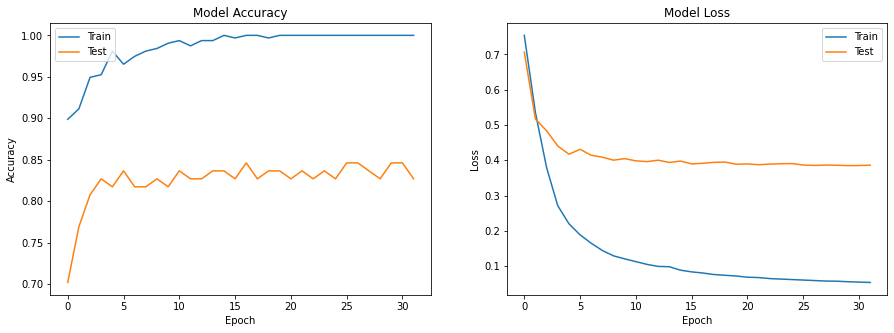

In [16]:
plot_metrics(history_array, no_epochs)

In [22]:
conf_matrix = metrics.confusion_matrix(Y_val.argmax(axis = 1), model_best.predict([X_val_cc, X_val_mlo]).argmax(axis = 1))
print_cm(conf_matrix, list(dict_valores.keys()))

2/2 [==============================] - 3s 1s/step
                    benigno seguimiento     maligno 
        benigno        24.0         0.0         4.0 
    seguimiento         3.0         1.0         0.0 
        maligno         7.0         0.0        13.0 


Mostramos las métricas de resultados según categoría para poder evaluar el desempeño de la red en cada caso.

In [21]:
classif_report = metrics.classification_report(Y_val.argmax(axis = 1), model_best.predict([X_val_cc, X_val_mlo]).argmax(axis = 1),
                                               target_names = list(dict_valores.keys()))
print(classif_report)

2/2 [==============================] - 7s 1s/step
              precision    recall  f1-score   support

     benigno       0.71      0.86      0.77        28
 seguimiento       1.00      0.25      0.40         4
     maligno       0.76      0.65      0.70        20

    accuracy                           0.73        52
   macro avg       0.82      0.59      0.63        52
weighted avg       0.75      0.73      0.72        52



# Guardamos las metricas

In [33]:
import pickle
import json

# Function to convert numpy types to native Python types
def convert_to_native_types(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(v) for v in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_to_native_types(v) for v in obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    else:
        return obj

# Assuming history_list contains History objects
# Extract the history dictionaries
history_dicts = [convert_to_native_types(hist.history) for hist in history_list]

# Save the history dictionaries using pickle
with open('history_DN201.pkl', 'wb') as file:
    pickle.dump(history_dicts, file)

# Save the history dictionaries using JSON
with open('history_DN201.json', 'w') as file:
    json.dump(history_dicts, file)
